In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from scripts.ImageDataset import ImageDataset
from models.ResNet import ResNet
from models.SimpleCNN import SimpleCNN
from models.FoodCNN import FoodCNN


from models.CustomNet import CustomNet

from utils.print_errors import print_errors

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [21]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
CUDA version: 12.1
Device count: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1060 6GB


In [22]:
ltf = pd.read_csv('./ground_truth/foods_names.csv')
ltf = ltf.drop(columns=['Index'])
label_to_foods = ltf.to_dict()['Food']

In [23]:
train_gt_path = './ground_truth/train_small.csv'
test_gt_path = './ground_truth/new_val_info.csv'
train_unlabel_path = './ground_truth/unlabeled.csv'

train_image_path = './train_set/'
test_image_path = './val_set/'

train_gt_df = pd.read_csv(train_gt_path, header=None, names=['image_id', 'label'])
test_gt_df = pd.read_csv(test_gt_path, header=None, names=['image_id', 'label'])
train_dataset = ImageDataset(train_gt_df, train_image_path, train=True, labels = True)
test_dataset = ImageDataset(test_gt_df, test_image_path, train=False, labels = True)

print('---- Dataset summary ----')
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

batch_size = 32

---- Dataset summary ----
Train dataset size: 5020
Test dataset size: 11915


## Analisi del dataset

In [5]:
train_labels = list(np.unique(train_dataset.get_labels()))
all_labels = list(np.arange(0, 251))

for l in all_labels:
    if l not in train_labels:
        print('Missing:', l)

## Addestramento delle reti

In [6]:
from models.CustomNet import CustomNet
import torchvision.models as models
from torch import nn

save_path = './models/trained_models/'
num_epochs = 10

In [7]:
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracy, val_accuracy):
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.legend()
    plt.show()

### ResNet18

In [8]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc = nn.Linear(resnet18.fc.in_features, 251)
for param in resnet18.fc.parameters():
    param.requires_grad = True

parameters = resnet18.fc.parameters()
resnet18 = CustomNet(custom_model=resnet18, model_name='resnet18', device='cuda')
path_to_model = save_path + f'resnet18_{num_epochs}.pth'
if not (os.path.exists(path_to_model)):
    train_loss, val_loss, train_accuracy, val_accuracy = resnet18.train_model(train_loader, val_loader, parameters, num_epochs=10, lr=0.001, save_path=save_path)

    plot_accuracy(train_accuracy, val_accuracy)
    plot_loss(train_loss, val_loss)
else:
    resnet18.load_model(path_to_model)
    print('Model loaded')   

c:\Users\Massimo\Desktop\VisualFoodRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Massimo\Desktop\VisualFoodRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded


c:\Users\Massimo\Desktop\VisualFoodRecognition\models\CustomNet.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(path))


### EfficientNet

In [9]:
efficientnet = models.efficientnet_b0(pretrained=True)
for param in efficientnet.parameters():
    param.requires_grad = False

num_features = efficientnet.classifier[-1].in_features
efficientnet.classifier[-1] = nn.Linear(num_features, 251)

for param in efficientnet.classifier.parameters():
    param.requires_grad = True

parameters = efficientnet.classifier.parameters()
custom_efficientnet = CustomNet(custom_model=efficientnet, model_name='efficientnet_b0', device='cuda')
path_to_model = save_path + f'efficientnet_b0_{num_epochs}.pth'
if not (os.path.exists(path_to_model)):
    train_loss, val_loss, train_accuracy, val_accuracy = custom_efficientnet.train_model(train_loader, val_loader, parameters, num_epochs=10, lr=0.001, save_path=save_path)

    plot_accuracy(train_accuracy, val_accuracy)
    plot_loss(train_loss, val_loss)
else:
    custom_efficientnet.load_model(path_to_model)
    print('Model loaded')

c:\Users\Massimo\Desktop\VisualFoodRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded


### VGG16

In [10]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False

num_features = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_features, 251)

for param in vgg16.classifier[-1].parameters():
    param.requires_grad = True

parameters = vgg16.classifier[-1].parameters()
custom_vgg16 = CustomNet(custom_model=vgg16, model_name='vgg16', device='cuda')
path_to_model = save_path + f'vgg16_{num_epochs}.pth'
if not (os.path.exists(path_to_model)):
    train_loss, val_loss, train_accuracy, val_accuracy = custom_vgg16.train_model(train_loader, val_loader, parameters, num_epochs=10, lr=0.001, save_path=save_path)

    plot_accuracy(train_accuracy, val_accuracy)
    plot_loss(train_loss, val_loss)
else:
    custom_vgg16.load_model(path_to_model)
    print('Model loaded')

c:\Users\Massimo\Desktop\VisualFoodRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model loaded


## Prediction with models

In [11]:
unlabel_train_df = pd.read_csv(train_unlabel_path, header=None, names=['image_id'])
models_list =['resnet18', 'efficientnet','vgg16']

In [12]:
# Dataset composto inizialmente dal train poi dal train più le immagini con le label predette
iterative_train_dataset = train_dataset

# Dataset commposto dalle immagini senza label che parte di cui verrà aggiunta al train successivo e rimossa da unlabel_train_dataset
predictions_df = unlabel_train_df.sample(frac=0.05, random_state=42, replace=False)
predictions_dataset = ImageDataset(predictions_df, train_image_path, train=False, labels = False)
predictions_loader = DataLoader(predictions_dataset, batch_size=batch_size, shuffle=False)

# Valuto le performance del modello sul test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('------ Dataset summary ------')
print('Train dataset size:', len(train_dataset))
print('Images to predict labels:', len(predictions_dataset))
print('Test dataset size:', len(test_dataset))

------ Dataset summary ------
Train dataset size: 5020
Images to predict labels: 5673
Test dataset size: 11915


In [13]:
def train_models(model_list, data_dataset, prediction_loader, num_epochs):
    models_accuracies = []
    models_predictions = []
    for model in model_list:
        print(f'Training model {model}')
        model = FoodCNN(model_name=model)
        _,_,_, val_accuracy = model.train_model(data_dataset, validation=0.1, num_epochs=num_epochs)
        models_accuracies.append(val_accuracy)
        predictions = model.predict(prediction_loader)
        models_predictions.append(predictions)

    return models_accuracies, models_predictions

# Prendo i modelli e li alleno con l'iterative train dataset TODO passare 
models_accuracies, models_predictions = train_models(models_list, iterative_train_dataset, predictions_loader, num_epochs=5)

Training model resnet18


Epoch 1/5: 100%|██████████████████████| 142/142 [00:57<00:00,  2.49it/s, accuracy=0.0142, loss=5.24]


Train Accuracy: 0.0142
Validation Loss: 5.1885, Validation Accuracy: 0.0438


Epoch 2/5: 100%|███████████████████████| 142/142 [00:56<00:00,  2.50it/s, accuracy=0.077, loss=4.66]


Train Accuracy: 0.0770
Validation Loss: 4.8501, Validation Accuracy: 0.0837


Epoch 3/5: 100%|███████████████████████| 142/142 [00:56<00:00,  2.50it/s, accuracy=0.145, loss=5.07]


Train Accuracy: 0.1448
Validation Loss: 4.5952, Validation Accuracy: 0.1175


Epoch 4/5: 100%|████████████████████████| 142/142 [00:56<00:00,  2.50it/s, accuracy=0.21, loss=4.42]


Train Accuracy: 0.2098
Validation Loss: 4.4599, Validation Accuracy: 0.1135


Epoch 5/5: 100%|███████████████████████| 142/142 [00:56<00:00,  2.51it/s, accuracy=0.252, loss=4.46]


Train Accuracy: 0.2517
Validation Loss: 4.3583, Validation Accuracy: 0.1673


100%|██████████| 178/178 [00:20<00:00,  8.55it/s]
c:\Users\Massimo\Desktop\VisualFoodRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Massimo\Desktop\VisualFoodRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model efficientnet


Epoch 1/5: 100%|██████████████████████| 142/142 [00:51<00:00,  2.78it/s, accuracy=0.0317, loss=5.14]


Train Accuracy: 0.0317
Validation Loss: 4.9896, Validation Accuracy: 0.0936


Epoch 2/5: 100%|███████████████████████| 142/142 [00:51<00:00,  2.78it/s, accuracy=0.195, loss=4.01]


Train Accuracy: 0.1948
Validation Loss: 4.6078, Validation Accuracy: 0.1335


Epoch 3/5: 100%|███████████████████████| 142/142 [00:51<00:00,  2.74it/s, accuracy=0.285, loss=4.91]


Train Accuracy: 0.2846
Validation Loss: 4.3805, Validation Accuracy: 0.1554


Epoch 4/5: 100%|███████████████████████| 142/142 [00:51<00:00,  2.75it/s, accuracy=0.351, loss=3.31]


Train Accuracy: 0.3510
Validation Loss: 4.2483, Validation Accuracy: 0.1713


Epoch 5/5: 100%|██████████████████████████| 142/142 [00:51<00:00,  2.77it/s, accuracy=0.4, loss=3.3]


Train Accuracy: 0.4000
Validation Loss: 4.1410, Validation Accuracy: 0.1673


100%|██████████| 178/178 [00:27<00:00,  6.53it/s]
c:\Users\Massimo\Desktop\VisualFoodRecognition\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model vgg16


Epoch 1/5: 100%|███████████████████████| 142/142 [01:08<00:00,  2.08it/s, accuracy=0.0502, loss=6.5]


Train Accuracy: 0.0502
Validation Loss: 4.6966, Validation Accuracy: 0.1116


Epoch 2/5: 100%|███████████████████████| 142/142 [01:08<00:00,  2.06it/s, accuracy=0.162, loss=4.67]


Train Accuracy: 0.1625
Validation Loss: 4.7255, Validation Accuracy: 0.1275


Epoch 3/5: 100%|███████████████████████| 142/142 [01:08<00:00,  2.08it/s, accuracy=0.213, loss=3.79]


Train Accuracy: 0.2127
Validation Loss: 4.7501, Validation Accuracy: 0.1335


Epoch 4/5: 100%|███████████████████████| 142/142 [01:08<00:00,  2.08it/s, accuracy=0.251, loss=5.35]


Train Accuracy: 0.2508
Validation Loss: 4.8004, Validation Accuracy: 0.1414


Epoch 5/5: 100%|███████████████████████| 142/142 [01:08<00:00,  2.06it/s, accuracy=0.279, loss=2.24]


Train Accuracy: 0.2791
Validation Loss: 4.7590, Validation Accuracy: 0.1673


100%|██████████| 178/178 [00:50<00:00,  3.54it/s]


In [24]:
m_a = []
for a in models_accuracies:
    m_a.append(a[4])

print('Model accuracies:', m_a)
weights = np.array(m_a) / np.sum(m_a)
print('Weights:', weights)

Model accuracies: [0.16733067729083664, 0.16733067729083664, 0.16733067729083664]
Weights: [0.33333333 0.33333333 0.33333333]


In [25]:
def get_agreement_and_treshold(predictions, weights, confidence):
    res_predictions, eff_predictions, vgg_predictions = predictions
    res_weight, eff_weight, vgg_weight = weights
    images_idx = []
    images_label = []
    images_to_add = 0
    for i in range(len(res_predictions)):
        res_label = np.argmax(res_predictions[i])
        eff_label = np.argmax(eff_predictions[i])
        vgg_label = np.argmax(vgg_predictions[i])

        res_confidence = res_predictions[i][res_label]
        eff_confidence = eff_predictions[i][eff_label]
        vgg_confidence = vgg_predictions[i][vgg_label]

        if res_label == eff_label and res_label == vgg_label:
            models_confidence = res_confidence * res_weight + eff_confidence * eff_weight + vgg_confidence * vgg_weight
            if models_confidence > confidence:
                images_to_add += 1
                images_idx.append(i)
                images_label.append(res_label)

    print(f'Images to add: {images_to_add}')
    return images_to_add, images_idx, images_label
# gli output dei modelli sono dei vettori di probabilità, calcolo quando tutti e tre i modelli sono d'accordo e hanno una confidenza maggiore di 0.75
number_of_images, images_index, images_label = get_agreement_and_treshold(models_predictions, weights, confidence=0.75) 

Images to add: 11


In [31]:
def update_datasets(images_idx, images_label, predictions_dataset, train_dataset, unlabel_df):
    for i in range(len(images_idx)):
        # Ottengo l'immagine e la sua label dal dataset delle predizioni
        image_idx = images_idx[i]
        image_label = images_label[i]
        image_id = predictions_dataset.get_image_id(image_idx)
        # Aggiungo l'immagine al dataset di train iterativo
        train_dataset.add_image(image_id, image_label)
        # Rimuovo l'immagine dal dataset delle immagini senza label così da non aggiungerla nuovamente
        unlabel_df = unlabel_df[unlabel_df['image_id'] != image_id]

    return train_dataset, unlabel_df

# Prendo le immagini che hanno superato questo test, assegno loro le label le rimuovo dall' unlabel_set e le aggiungo all'iterative train dataset
# Lunghezze prima dell'aggiornamento
initial_train_len = len(iterative_train_dataset)
initial_unlabel_len = len(unlabel_train_df)

# Image index: indici delle immagini all'interno del train set
train_dataset, unlabel_train_df = update_datasets(images_index, images_label, predictions_dataset, train_dataset, unlabel_train_df)

# Lunghezze dopo l'aggiornamento
final_train_len = len(train_dataset)
final_unlabel_len = len(unlabel_train_df)

print(f"Train dataset size: {initial_train_len} -> {final_train_len}")
print(f"Unlabel dataset size: {initial_unlabel_len} -> {final_unlabel_len}")

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types

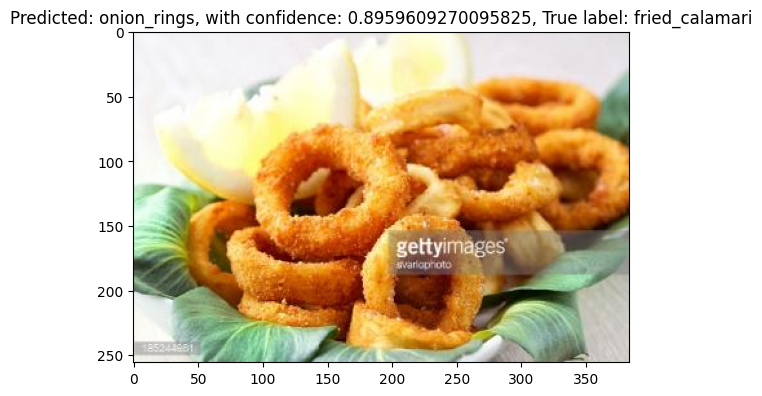

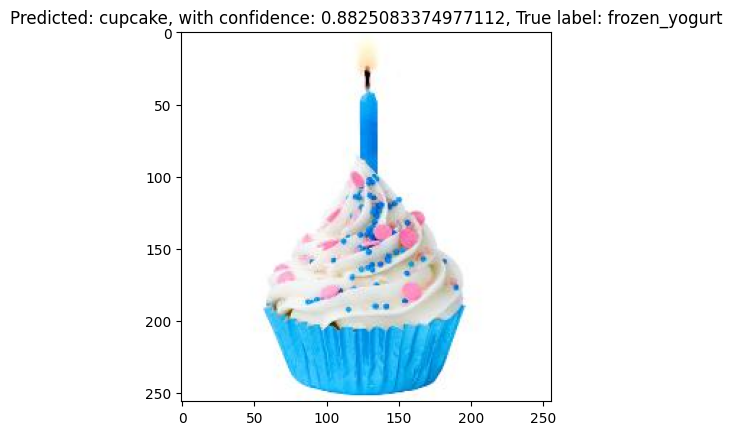

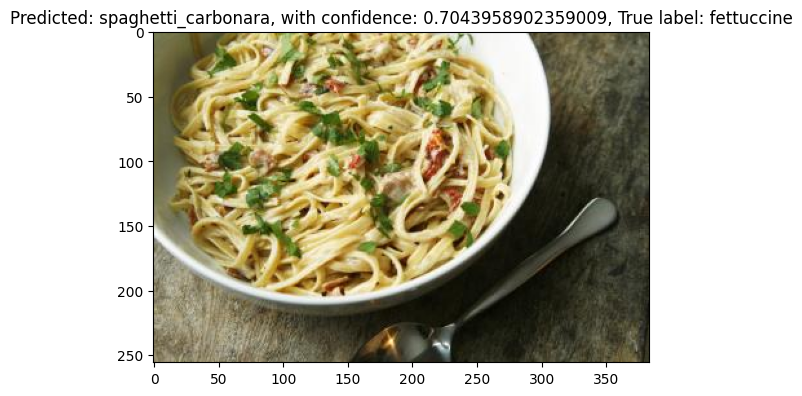

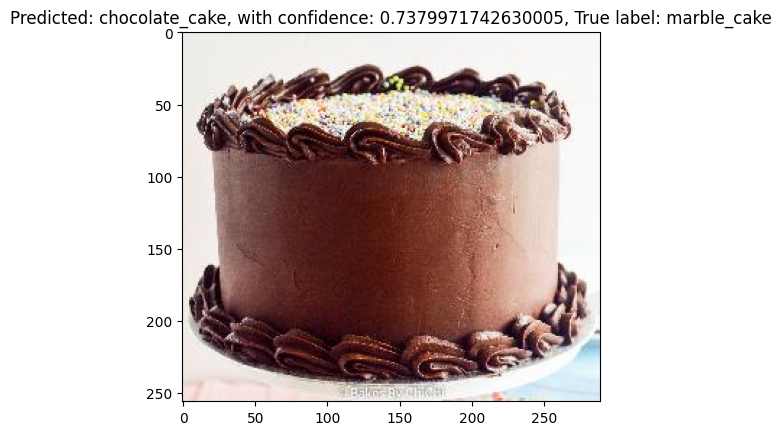

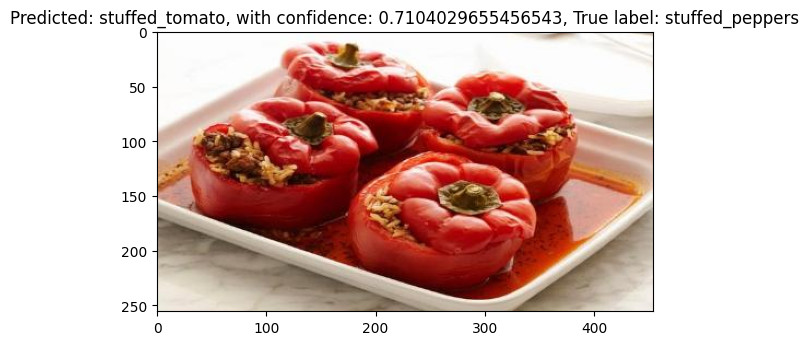

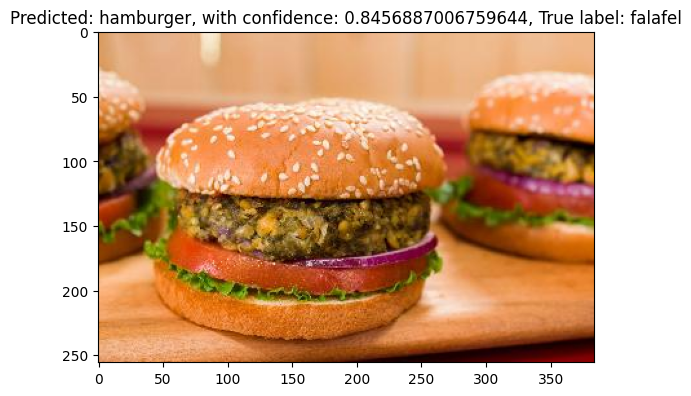

In [25]:
correct = 0
wrong = 0

models_weights = [0.35, 0.35, 0.3]
gt_labels = test_dataset.get_labels()

for idx in range(len(test_dataset)):
    predictions = [resnet18_predictions[idx], efficientnet_predictions[idx], vgg16_predictions[idx]]
    labels_predictions = [np.argmax(p) for p in predictions]
    if labels_predictions[0] == labels_predictions[1] and labels_predictions[1] == labels_predictions[2]:
        weight_prediction = models_weights[0] * predictions[0] + models_weights[1] * predictions[1] + models_weights[2] * predictions[2]
        label = np.argmax(weight_prediction)
        threshold = 0.70
        if weight_prediction[label] > threshold:
            if label != gt_labels[idx]:
                plt.figure()
                plt.imshow(test_dataset.get_image(idx))
                plt.title(f'Predicted: {label_to_foods[label]}, with confidence: {weight_prediction[label]}, True label: {label_to_foods[gt_labels[idx]]}')
                plt.show()